In [8]:
import random
import pickle

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from einops import rearrange, repeat
import pandas as pd

from methods.ldm.sampler import LDMSampler
from methods.utils import get_root_dir, load_yaml_param_settings
from methods.ldm.denoising_diffusion_pytorch.denoising_diffusion_pytorch import save_image, save_image_unconditional

In [2]:
# load the sampler
sampler = LDMSampler(stage2_ckpt=get_root_dir().joinpath('methods', 'ldm', 'saved_models', 'stage2-20.ckpt'))
trainer = sampler.trainer

self.X_train.shape: (4044, 4, 128, 128)
self.X_test.shape: (1011, 4, 128, 128)
loading from version 1.8.11


In [3]:
# settings
config = load_yaml_param_settings(get_root_dir().joinpath('configs', 'ldm.yaml'))
cmap = ListedColormap(['C3', 'C2', 'C1', 'C0', '#D3D3D3'])

### Conditional sampling with randomly-sampled $X_{cond}$ from the test set.

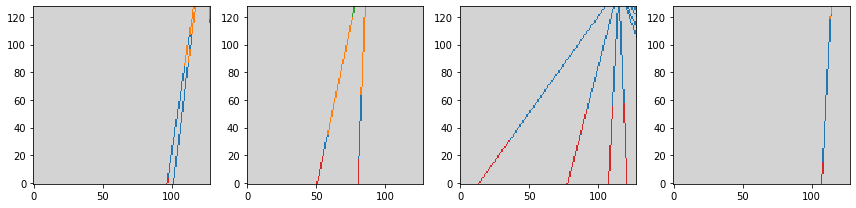

In [13]:
random.seed(0)
np.random.seed(0)
# ================

num_samples = 9

# z_cond
X_cond = []
for _ in range(num_samples):
    i = np.random.choice(len(trainer.ds.dataset))
    x, x_cond = trainer.ds.dataset[i]  # (c h w)
    X_cond.append(x_cond.numpy())
X_cond = torch.from_numpy(np.array(X_cond))  # (b c h w); b == num_samples
z_cond = trainer.pretrained_encoder_cond(X_cond.to(trainer.accelerator.device))  # (b c h' w')


# ================
# plot the first 4 of x_cond
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(torch.argmax(X_cond, dim=1)[i], interpolation='nearest', cmap=cmap, aspect='auto')
    ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [14]:
# sample z
z_gen = trainer.ema.ema_model.sample(z_cond, batch_size=num_samples)
print('z_gen.shape:', z_gen.shape)

sampling loop time step: 100%|██████████| 1000/1000 [01:24<00:00, 11.78it/s]

z_gen.shape: torch.Size([9, 4, 64, 64])


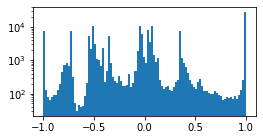

In [15]:
# z histogram
plt.figure(figsize=(4, 2))
plt.hist(z_gen.cpu().detach().numpy().flatten(), bins=100, log=True)
plt.show()

In [17]:
# apply decoder
x_gen = trainer.pretrained_decoder(z_gen)  # (b c h w)
x_gen = x_gen.cpu().detach()
x_gen = x_gen.argmax(dim=1)[:,None,:,:].float()
print('x_gen.shape:', x_gen.shape)

x_gen.shape: torch.Size([9, 1, 128, 128])


In [23]:
# plot
fname = get_root_dir().joinpath('methods', 'ldm', 'results', '.sample_jupyter_conditional.png')
save_image(X_cond, x_gen, fname, config['dataset']['in_channels'], 0, False)

### Reconstructability of $D$

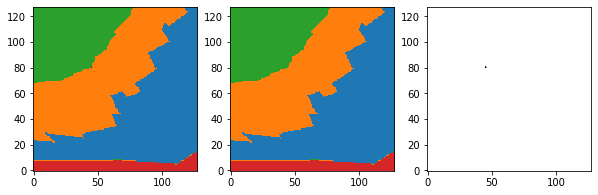

In [30]:
# take a sample x
num_samples = 1
for _ in range(num_samples):
    i = np.random.choice(len(trainer.ds.dataset))
    x, x_cond = trainer.ds.dataset[i]  # (c h w)

# forward
device = trainer.accelerator.device
z = trainer.pretrained_encoder(x[None, :, :, :].to(device))  # (b c h' w')
xhat = trainer.pretrained_decoder(z)[0].cpu()  # (b c h w)

# plot
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
# axes[0].imshow(x.argmax(dim=0))
axes[0].imshow(x.argmax(dim=0), cmap=cmap, vmin=0, vmax=config['dataset']['in_channels'])
axes[0].invert_yaxis()
axes[1].imshow(xhat.argmax(dim=0), cmap=cmap, vmin=0, vmax=config['dataset']['in_channels'])
axes[1].invert_yaxis()
axes[2].imshow(torch.abs(xhat.argmax(dim=0) - x.argmax(dim=0)), vmin=0, vmax=1, cmap='binary')
axes[2].invert_yaxis()
plt.show()

In [35]:
# create X
xs = []
num_samples = 64
for _ in range(num_samples):
    i = np.random.choice(len(trainer.ds))
    x, x_cond = trainer.ds.dataset[i]  # (c h w)
    xs.append(x.numpy())
xs = torch.from_numpy(np.array(xs))

# forward
device = trainer.accelerator.device
z = trainer.pretrained_encoder(xs.to(device))  # (b c h' w')
xhat = trainer.pretrained_decoder(z).cpu()  # (b c h w)

# compute the error rate
error_rate = torch.torch.abs(xhat.argmax(dim=1) - xs.argmax(dim=1))
print('error rate:', error_rate.float().mean())

error_rate = torch.nn.functional.cross_entropy(rearrange(xhat, 'b c h w -> (b h w) c'), rearrange(xs, 'b c h w -> (b h w) c').argmax(dim=-1))
print('CE error_rate:', error_rate.item())

"""
(a)
- error rate: tensor(0.0006)
- CE error_rate: 0.004543143790215254

(c)
- error rate: tensor(0.0005)
- CE error_rate: 0.0023470637388527393
""";

error rate: tensor(3.5286e-05)
CE error_rate: 0.0002533556253183633


### Unconditional sampling

In [4]:
# settings
num_samples = 9

In [5]:
# sample z
trainer.ema.ema_model.eval()
z_gen = trainer.ema.ema_model.sample(z_cond=None, batch_size=num_samples)
print('z_gen.shape:', z_gen.shape)

sampling loop time step: 100%|██████████| 1000/1000 [01:25<00:00, 11.66it/s]

z_gen.shape: torch.Size([9, 4, 64, 64])


In [6]:
# apply decoder
x_gen = trainer.pretrained_decoder(z_gen)  # (b c h w)
x_gen = x_gen.cpu().detach()
x_gen = x_gen.argmax(dim=1)[:,None,:,:].float()
print('x_gen.shape:', x_gen.shape)

x_gen.shape: torch.Size([9, 1, 128, 128])


In [7]:
# plot
fname = get_root_dir().joinpath('methods', 'ldm', 'results', '.sample_jupyter_unconditional.png')
save_image_unconditional(x_gen, fname, config['dataset']['in_channels'])

### Transitional Visualization: $x_T$ to $x_0$

In [43]:
# settings
num_samples = 9

In [44]:
# z_cond
X_cond = []
for _ in range(num_samples):
    i = np.random.choice(len(trainer.ds))
    x, x_cond = trainer.ds.dataset[i]  # (c h w)
    X_cond.append(x_cond.numpy())
X_cond = torch.from_numpy(np.array(X_cond))  # (b c h w); b == num_samples
z_cond = trainer.pretrained_encoder_cond(X_cond.to(trainer.accelerator.device))  # (b c h' w')

In [45]:
# sample z
trainer.ema.ema_model.eval()
z_gen = trainer.ema.ema_model.sample(z_cond=z_cond, batch_size=num_samples, return_all_timesteps=True)
print('z_gen.shape:', z_gen.shape)

sampling loop time step: 100%|██████████| 1000/1000 [01:25<00:00, 11.69it/s]

z_gen.shape: torch.Size([9, 1001, 4, 64, 64])


In [46]:
n_transitional_steps = 5
visualizing_steps = np.linspace(0, z_gen.shape[1] - 1, n_transitional_steps).astype(int)
print('visualizing_steps:', visualizing_steps)

for step in visualizing_steps:
    z_gen_ = z_gen[:, step]  # (b c h w)
    
    # apply decoder
    x_gen = trainer.pretrained_decoder(z_gen_)  # (b c h w)
    x_gen = x_gen.cpu().detach()
    x_gen = x_gen.argmax(dim=1)[:,None,:,:].float()
    print('x_gen.shape:', x_gen.shape)

    fname = get_root_dir().joinpath('methods', 'ldm', 'results', f'.sample_jupyter_transitional_{step}.png')
    save_image(X_cond, x_gen, fname, config['dataset']['in_channels'], 0, False)

visualizing_steps: [   0  250  500  750 1000]
x_gen.shape: torch.Size([9, 1, 128, 128])
x_gen.shape: torch.Size([9, 1, 128, 128])
x_gen.shape: torch.Size([9, 1, 128, 128])
x_gen.shape: torch.Size([9, 1, 128, 128])
x_gen.shape: torch.Size([9, 1, 128, 128])


### Conditional sampling given specific $X_{cond}$

In [56]:
# settings
num_samples = 9

In [57]:
# z_cond
X_cond = []
X = []
for _ in range(num_samples):
    i = np.random.choice(len(trainer.ds))
    x, x_cond = trainer.ds.dataset[i]  # (c h w)
    X_cond.append(x_cond.numpy())
    X.append(x.numpy())
X = torch.from_numpy(np.array(X))
X_cond = torch.from_numpy(np.array(X_cond))  # (b c h w); b == num_samples
z_cond = trainer.pretrained_encoder_cond(X_cond.to(trainer.accelerator.device))  # (b c h' w')

# x_cond
select_idx = 2
x = X[select_idx]
x_cond = X_cond[select_idx]

# repeat
x = repeat(x, 'c h w -> b c h w', b=num_samples)  # (b c h w)
x_cond = repeat(x_cond, 'c h w -> b c h w', b=num_samples)  # (b c h w)

# z_q_cond
x_cond = torch.from_numpy(np.array(x_cond)).float()  # (b c h w); b == num_samples
z_cond = trainer.pretrained_encoder_cond(x_cond.to(trainer.accelerator.device))  # (b c h' w')

sampling loop time step: 100%|██████████| 1000/1000 [01:24<00:00, 11.82it/s]


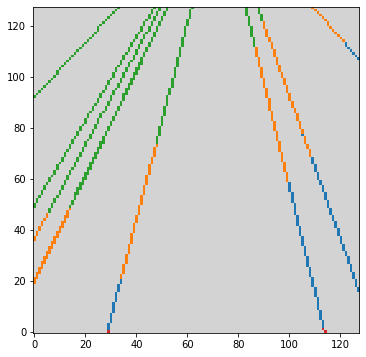

In [76]:
# check x_cond
cmap = ListedColormap(['C3', 'C2', 'C1', 'C0', '#D3D3D3'])
plt.figure(figsize=(6, 6))
plt.imshow(x_cond.argmax(axis=1)[0], cmap=cmap, interpolation='nearest')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# sample z
trainer.ema.ema_model.eval()
z_gen = trainer.ema.ema_model.sample(z_cond, batch_size=num_samples)

In [77]:
# apply decoder
x_gen = trainer.pretrained_decoder(z_gen)  # (b c h w)
x_gen = x_gen.cpu().detach()
x_gen = x_gen.argmax(dim=1)[:,None,:,:].float()
print('x_gen.shape:', x_gen.shape)

x_gen.shape: torch.Size([9, 1, 128, 128])


In [78]:
# plot
fname = get_root_dir().joinpath('methods', 'ldm', 'results', '.x_c_to_many.png')
save_image(x_cond, x_gen, fname, config['dataset']['in_channels'], 0, False)

fname = get_root_dir().joinpath('methods', 'ldm', 'results', '.x_of_x_c_to_many.png')
save_image(x, x_gen, fname, config['dataset']['in_channels'], 0, False)

### Bulk unconditonal sampling 

In [ ]:
# sample many and save

n_samples = 1000
batch_size = 32

n_iters = np.ceil(n_samples / batch_size).astype(int)
for i in range(n_iters):
# for i in [20, 21, 22, 23, 24]:
    # sample z
    trainer.ema.ema_model.eval()
    z_gen = trainer.ema.ema_model.sample(z_cond=None, batch_size=batch_size)  # (b d h' w')
    
    # apply decoder
    x_gen = trainer.pretrained_decoder(z_gen)  # (b c h w)
    x_gen = x_gen.cpu().detach()
    x_gen = x_gen.argmax(dim=1)[:,None,:,:].float()  # (b 1 h w)
    
    # save
    fname = get_root_dir().joinpath('methods', 'ldm', 'results', 'unconditional_sampling', '(a)', f'x_gen_{i}.npy')
    with open(fname, 'wb') as f:
        np.save(f, x_gen[:, 0, : ,:])
    
    # empty cuda memory
    torch.cuda.empty_cache()

In [ ]:
del x_gen
torch.cuda.empty_cache()

### Bulk conditonal sampling 

In [ ]:
data_loader = trainer.ds
n_samples = len(trainer.ds.dataset)
sampling_batch_size = 32
print('n_samples:', n_samples)

In [ ]:
X_cond = []
n_iters = np.ceil(n_samples / sampling_batch_size).astype(int)
for i in range(n_iters):
    print(f'{round(i/n_iters * 100)} % ..')
    x, x_cond = data_loader[i]  # (c h w)
    
    # z_cond
    x_cond = repeat(x_cond, 'c h w -> b c h w', b=sampling_batch_size)  # (b c h w)
    z_cond = trainer.pretrained_encoder_cond(x_cond.to(trainer.accelerator.device))  # (b c h' w')
    
    # sample z
    z_gen = trainer.ema.ema_model.sample(z_cond, batch_size=sampling_batch_size)
    
    # apply decoder
    x_gen = trainer.pretrained_decoder(z_gen)  # (b c h w)
    x_gen = x_gen.cpu().detach()
#     x_gen = x_gen.argmax(dim=1)[:,None,:,:].float()  # (b 1 h w)
    
    # save (x, x_cond, x_gen) by pickle
    # -1 for specifying the empty facies.
    data = {'x': x.numpy(),  # (1 c h w)
            'x_cond': x_cond.numpy(),  # (1 c h w)
            'x_gen': x_gen.numpy(),  # (b c h w)
           }
    fname = get_root_dir().joinpath('methods', 'ldm', 'results', 'conditional_sampling', '(a)', f'x_gen_{i}.pkl')
    with open(fname, 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)